<h1 style="color:#AB4646;font-size:50px;"> ASSIGNMENT<br>Text-based audio classification</h1>

# PART B - Classification

To run the cells in this notebook you'll need to install the following Python dependencies:
 * `numpy`
 * `sklearn`
 * `matplotlib`

If you have not installed them you should be able to do so by running: `pip install numpy sklearn matplotlib`.

In [95]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import utils
import random
import collections
import numpy
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.core.display import display, HTML

import seaborn as sns; # for visualizing confusion matrix
import pandas as pd #python library for data manipulation and analysis

try:  # This is for compatiblitily python2/python3 of xrange function
    xrange
except NameError:
    xrange = range

### Load previously created dataset

Set `DATASET_NAME` to the dataset you want to load.

In [89]:
# Load dataset from saved file
DATASET_NAME = 'instruments'
dataset = utils.load_from_json('%s.json' % DATASET_NAME)
print('Loaded dataset with %i classes:' % len(dataset))
for klass, sounds in dataset.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
class_names = list(dataset.keys())  # This is just for convenience, reused later on

Loaded dataset with 4 classes:
	Percussion: 200 sounds
	Wind instrument, woodwind instrument: 200 sounds
	Domestic sounds, home sounds: 200 sounds
	Bowed string instrument: 200 sounds


### 3) Define vector space

Here we create a prototype feature vector that will define the way in which our documetns are represented for classification purposes. You can set the number of dimensions of the vector sepace/feature vector by editing the parameter `NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR` below.

In [90]:
def build_tag_vector_space(n_dimensions, dataset, class_names): 
    # Get all tags in the dataset (the vocabulary)
    all_tags = list()
    for class_name in class_names:
        class_tags = utils.get_all_tags_from_class(class_name, dataset)
        all_tags += class_tags
        
    # Filter out tags with less frequency (get only top N tags)
    most_common_tags_counts = collections.Counter(all_tags).most_common(n_dimensions)
    most_common_tags = [tag for tag, _ in most_common_tags_counts]
    filtered_tags = [tag for tag in most_common_tags if tag in all_tags]
    
    # Build our prototype feature vector (unique list of tags), and print first 10 tags
    prototype_feature_vector = list(set(filtered_tags))
    print('Created prototype feature vector with %i dimensions (originally the space had %i dimensions)' % (
        len(prototype_feature_vector), len(set(all_tags))))
    print('Prototype vector tags (sorted by occurrence in filtered_tags):')
    for count, (tag, frequency) in enumerate(most_common_tags_counts):
        print('\t%i %s (%i ocurrences)' % (count + 1, tag, frequency))
    return prototype_feature_vector


NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 25 # Maximum number of dimensions for the feature vector.

prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

Created prototype feature vector with 25 dimensions (originally the space had 1450 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (271 ocurrences)
	2 single-note (206 ocurrences)
	3 good-sounds (153 ocurrences)
	4 neumann-U87 (153 ocurrences)
	5 pizzicato (88 ocurrences)
	6 violin (79 ocurrences)
	7 cello (72 ocurrences)
	8 vsco-2 (70 ocurrences)
	9 percussion (62 ocurrences)
	10 drum (53 ocurrences)
	11 saxophone (52 ocurrences)
	12 sax (49 ocurrences)
	13 strings (47 ocurrences)
	14 flute (45 ocurrences)
	15 woodwind (44 ocurrences)
	16 mezzoforte (44 ocurrences)
	17 non-vibrato (43 ocurrences)
	18 clarinet (38 ocurrences)
	19 vibrato (37 ocurrences)
	20 bassoon (33 ocurrences)
	21 double-bass (33 ocurrences)
	22 metal (32 ocurrences)
	23 oboe (31 ocurrences)
	24 midi-velocity-31 (29 ocurrences)
	25 woodwinds (28 ocurrences)


### 4) Project documents in the vector space

The cell below shows you how to project a document to the vector space, that is to say, how to get the feature vector of a specific sound form our dataset. You can run this cell multiple times to see the feature vector of different randomly chosen sounds.

In [91]:
# Example of getting feature vector from tags list...
random_sound = random.choice(dataset[random.choice(class_names)])
random_sound_tags = random_sound['tags']
random_sound_feature_vector = utils.get_feature_vector_from_tags(random_sound_tags, prototype_feature_vector)

display(HTML(utils.get_sound_embed_html(random_sound['id'])))
print('Chosen sound has tags:', ', '.join(random_sound_tags))
html = '<table><tr><td>'
html += '</td><td>'.join([tag for tag in prototype_feature_vector])
html += '</td></tr><tr><td>'
html += '</td><td>'.join(['x' if prototype_feature_vector[count] in random_sound_tags else '' 
                          for count, item in enumerate(random_sound_feature_vector)])
html += '</td></tr></table>'
display(HTML(html))

Chosen sound has tags: multiphonics, sax, saxophone, soprano-sax


drum,neumann-U87,single-note,percussion,vibrato,bassoon,midi-velocity-31,metal,flute,cello,saxophone,woodwind,oboe,sax,pizzicato,strings,multisample,double-bass,good-sounds,woodwinds,vsco-2,non-vibrato,mezzoforte,clarinet,violin
,,,,,,,,,,x,,,x,,,,,,,,,,,


### 5) Define train and testing set

In this cell we create the training and test sets that will be used to train our classifier and evaluate its accuracy.

Set the `PERCENTAGE_OF_TRAINING_DATA` to decide which percentage of data goes to training and which goes to testing.
Set `MAX_INPUT_TAGS_FOR_TESTING` to decide the maximum number of tags that will be used for each sound in the test send to predict its category. Set it to a big number (~20) to effectievly bypass this parameter.

In [105]:
def create_train_and_test_sets(dataset, class_names, percentage_training_data, 
                               max_input_tags_for_testing):
    training_set = dict()
    testing_set = dict()

    # Get 'n_training_sounds_per_class' sounds per class 
    for class_name, sounds in dataset.items():
        n_training_sounds_per_class = int(len(sounds) * percentage_training_data)
        sounds_from_class = sounds[:] # Copy the list so when we later shuffle it does not affect the original data 
        random.shuffle(sounds_from_class)
        training_set[class_name] = sounds_from_class[:n_training_sounds_per_class] # First sounds for training
        testing_set[class_name] = sounds_from_class[n_training_sounds_per_class:] # Following sounds for testing
     
        # Save a trimmed version of input tags for testing sounds
        for sound in testing_set[class_name]:
            sound['tags'] = random.sample(sound['tags'], min(max_input_tags_for_testing, len(sound['tags'])))

    print('Created training and testing sets with the following number of sounds:\n\tTrain\tTest')
    for class_name in class_names:
        training_sounds = training_set[class_name]
        testing_sounds = testing_set[class_name]
        print('\t%i\t%i\t%s' % (len(training_sounds), len(testing_sounds), class_name))
    return training_set, testing_set


PERCENTAGE_OF_TRAINING_DATA = 0.75 # Percentage of sounds that will be used for training (others are for testing)
MAX_INPUT_TAGS_FOR_TESTING = 20 # Use a big number to "omit" this parameter and use as many tags as originally are in the sound

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, 
    class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
    max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,
)

Created training and testing sets with the following number of sounds:
	Train	Test
	150	50	Percussion
	150	50	Wind instrument, woodwind instrument
	150	50	Domestic sounds, home sounds
	150	50	Bowed string instrument


### 6) Train classifier

Train the classifier with the training set that we prepared. User `CLASSIFIER_TYPE` parameter below to chose which type of classifier you want to use. This code currently supports Super Vector Mahcines (`svm`), and Decision Trees (`tree`). You might want to try adding further classifier types here.

Note that when using the `tree` classifier, the output of the tree is saved into an image and shown here. This is interesting to learn about what did the classifier learn. To show these trees, you'll need to install **Graphviz** and run the `dot` command line tool. 

In [106]:
def build_tag_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    return np.concatenate([[], tag_features])

def train_classifier(training_set, classifier_type, class_names, dataset_name, feature_vector_func, 
                     feature_vector_dimension_labels=None, tree_max_depth=5):
    
    # Prepare data for fitting classifier (as sklearn classifiers require)
    classes_vector = list()
    feature_vectors = list()
    for class_name, sounds in training_set.items():
        for count, sound in enumerate(sounds):
            # Use index of class name in class_names as numerical value (classifier internally represents 
            # class label as number)
            classes_vector.append(class_names.index(class_name))
            feature_vector = feature_vector_func(sound)
            feature_vectors.append(feature_vector)

    # Create and fit classifier
    print('Training classifier (%s) with %i sounds...' % (CLASSIFIER_TYPE, len(feature_vectors)))
    if classifier_type == 'svm':
        classifier = svm.LinearSVC()
        classifier.fit(feature_vectors, classes_vector)
    elif classifier_type == 'tree':
        classifier = tree.DecisionTreeClassifier(max_depth=tree_max_depth)
        classifier.fit(feature_vectors, classes_vector)
        
        # Plot classifier decision rules
        utils.print_tree_as_text(classifier, feature_vector_dimension_labels, class_names)
    
        # Alternatively you can do nicer plot with images, but this requires Graphviz to be installed
        # WARNING: do not run this if tree is too big, might freeze
        #out_filename = '%s_tree_%i.png' % (dataset_name, random.randint(1000,9999))
        #utils.export_tree_as_graph(
        #    classifier, feature_vector_dimension_labels, class_names=class_names, filename=out_filename)
        #display(HTML('<h4>Learned tree:</h4><img src="%s"/>' % out_filename))
    else:
        raise Exception('Bad classifier type!!!')
    
    print('done!')
    return classifier

CLASSIFIER_TYPE = 'svm' # Use 'svm' or 'tree'

classifier = train_classifier(
    training_set=training_set,
    classifier_type=CLASSIFIER_TYPE, 
    class_names=class_names, 
    dataset_name=DATASET_NAME,
    feature_vector_func=build_tag_feature_vector,
    feature_vector_dimension_labels=prototype_feature_vector,  # This is used to show the class names in the tree image
)

Training classifier (svm) with 600 sounds...
done!


### 7) Evaluate classification

The function below evaluated the classifier build in the previous cell and shows some results. 

Evaluating with 600 instances...
done!
436 correct predictions
164 wrong predictions
Overall accuracy 72.67%
Evaluating with 200 instances...
done!
145 correct predictions
55 wrong predictions
Overall accuracy 72.50%


0.725

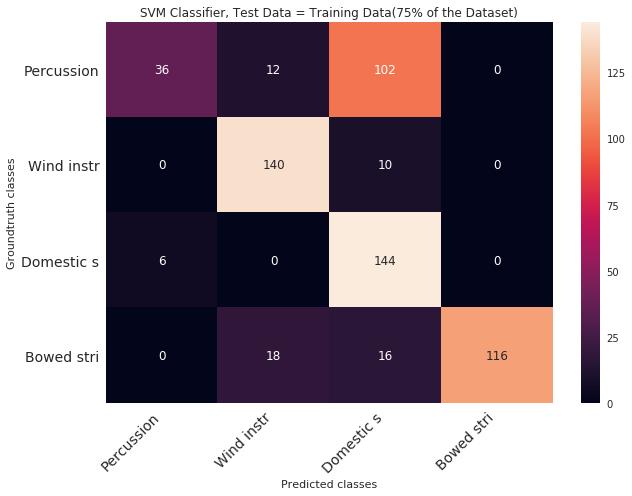

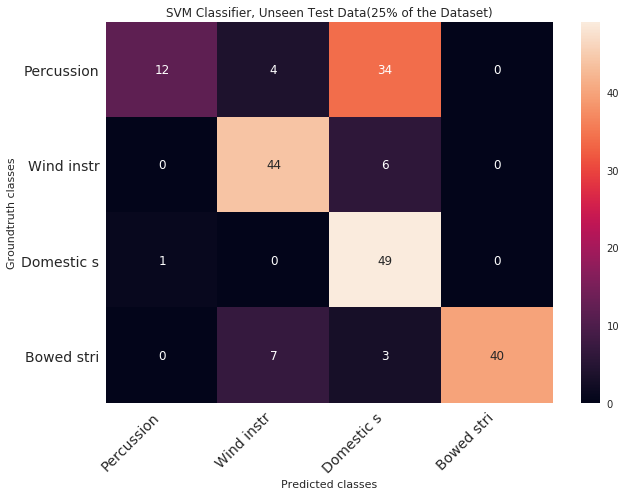

In [109]:
def evaluate_classifier(testing_set, classifier, class_names, feature_vector_func,caption='Confusion Matrix',show_confusion_matrix=True):
    # Test with testing set
    print('Evaluating with %i instances...' % sum([len(sounds) for sounds in testing_set.values()]))
    predicted_data = list()
    for class_name, sounds in testing_set.items():
        for count, sound in enumerate(sounds):
            feature_vector = feature_vector_func(sound)
            predicted_class_name = class_names[classifier.predict([feature_vector])[0]]
            predicted_data.append((sound['id'], class_name, predicted_class_name))     
    print('done!')

    # Compute overall accuracy
    good_predictions = len([1 for sid, cname, pname in predicted_data if cname == pname])
    wrong_predictions = len([1 for sid, cname, pname in predicted_data if cname != pname])
    print('%i correct predictions' % good_predictions)
    print('%i wrong predictions' % wrong_predictions)
    accuracy = float(good_predictions)/(good_predictions + wrong_predictions)
    print('Overall accuracy %.2f%%' % (100 * accuracy))
    
    if show_confusion_matrix:
        # Compute confusion matrix (further analysis)
        matrix = list()
        for class_name in class_names:
            predicted_classes = list()
            for sid, cname, pname in predicted_data:
                if cname == class_name:
                    predicted_classes.append(pname)
            matrix.append([predicted_classes.count(target_class) for target_class in class_names])

        # A seaborn heatmap is used to visualize the confusion matrix
        sns.set()
        shortened_class_names = [item[0:10] for item in class_names]
        df_cm = pd.DataFrame(matrix, index=shortened_class_names, columns=shortened_class_names)
        fig = plt.figure(figsize=(10,7))
        plt.clf()
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
        plt.ylabel('Groundtruth classes')
        plt.xlabel('Predicted classes')
        plt.title(caption)
    
    return accuracy
    
evaluate_classifier(
    testing_set=training_set,
    classifier=classifier,
    class_names=class_names,
    feature_vector_func=build_tag_feature_vector,
    caption='SVM Classifier, Test Data = Training Data(75% of the Dataset)'
)

evaluate_classifier(
    testing_set=testing_set,
    classifier=classifier,
    class_names=class_names,
    feature_vector_func=build_tag_feature_vector,
    caption='SVM Classifier, Unseen Test Data(25% of the Dataset)'
)

# PART C - Extra experiments

Here we add some more classification experiments to inspire yourself.

<h2 style="color:#AB4646;">SVM and Tree classifiers</h2>

Created prototype feature vector with 10 dimensions (originally the space had 1343 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (271 ocurrences)
	2 single-note (205 ocurrences)
	3 good-sounds (153 ocurrences)
	4 neumann-U87 (153 ocurrences)
	5 pizzicato (88 ocurrences)
	6 violin (79 ocurrences)
	7 cello (72 ocurrences)
	8 vsco-2 (70 ocurrences)
	9 percussion (55 ocurrences)
	10 saxophone (52 ocurrences)
Created training and testing sets with the following number of sounds:
	Train	Test
	150	50	Percussion
	150	50	Wind instrument, woodwind instrument
	150	50	Domestic sounds, home sounds
	150	50	Bowed string instrument
Training classifier (svm) with 600 sounds...
done!
[CASE 1]: Testing data is training data itself. This is to check overfitting
Evaluating with 600 instances...
done!
438 correct predictions
162 wrong predictions
Overall accuracy 73.00%
[CASE 2]: Testing data is unseen data.
Evaluating with 200 instances...
done!
143 correct predi

Created prototype feature vector with 10 dimensions (originally the space had 1320 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (270 ocurrences)
	2 single-note (204 ocurrences)
	3 good-sounds (153 ocurrences)
	4 neumann-U87 (153 ocurrences)
	5 pizzicato (88 ocurrences)
	6 violin (79 ocurrences)
	7 cello (72 ocurrences)
	8 vsco-2 (70 ocurrences)
	9 percussion (55 ocurrences)
	10 saxophone (52 ocurrences)
Created training and testing sets with the following number of sounds:
	Train	Test
	150	50	Percussion
	150	50	Wind instrument, woodwind instrument
	150	50	Domestic sounds, home sounds
	150	50	Bowed string instrument
Training classifier (svm) with 600 sounds...
if multisample =< 0.5: 
  |then if saxophone =< 0.5: 
  |  |then if violin =< 0.5: 
  |  |  |then if neumann-U87 =< 0.5: 
  |  |  |  |then if percussion =< 0.5: 
  |  |  |  |  |then Domestic sounds, home sounds
  |  |  |  |  |else Percussion
  |  |  |  |else Wind instrument, woodwind in

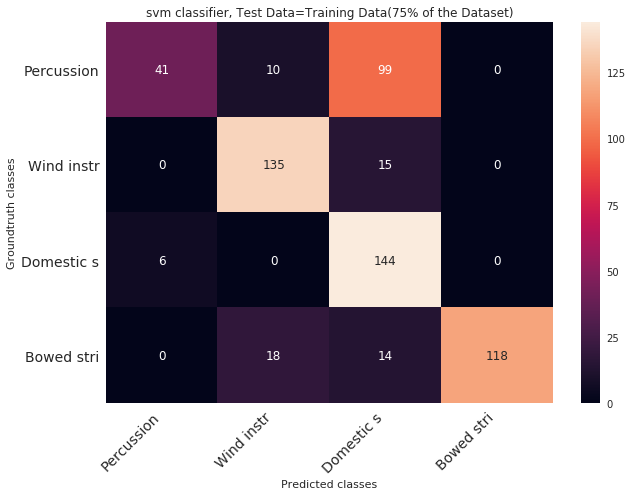

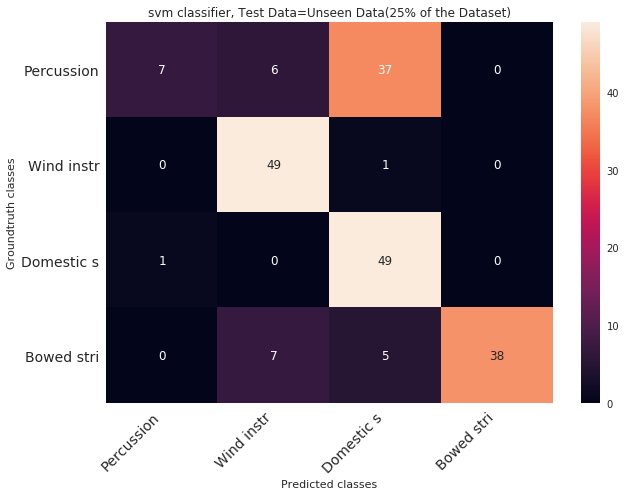

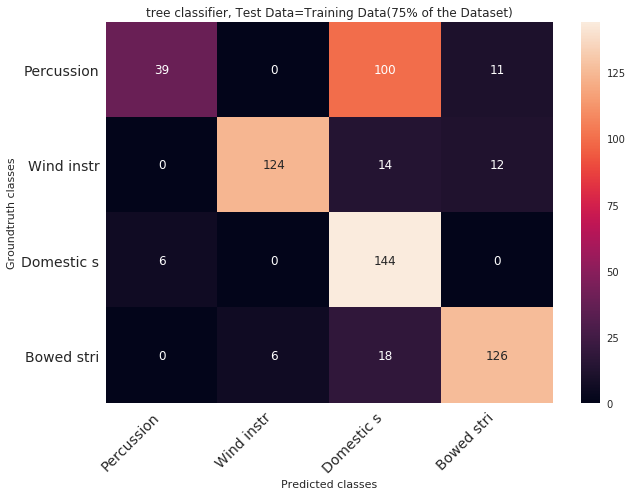

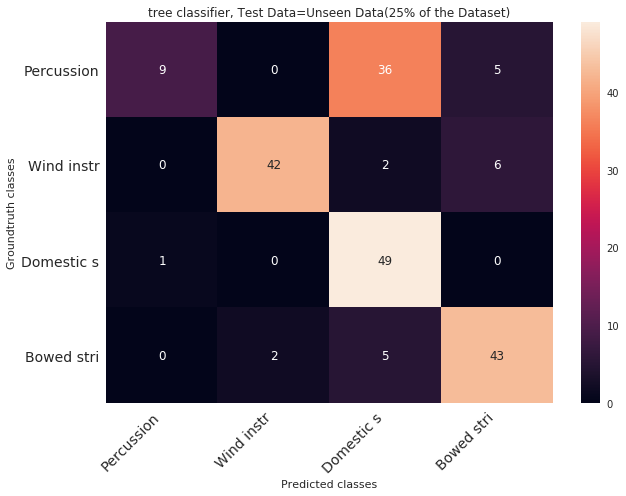

In [110]:
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 10
PERCENTAGE_OF_TRAINING_DATA = 0.75
MAX_INPUT_TAGS_FOR_TESTING = 10

for classifier_type in ['svm', 'tree']:  
    display(HTML('<h2>With %s classifier</h2>' % classifier_type.upper()))

    prototype_feature_vector = build_tag_vector_space(
        n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
        dataset=dataset,
        class_names=class_names,
    )
    training_set, testing_set = create_train_and_test_sets(
        dataset=dataset, 
        class_names=class_names,
        percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
        max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,   
    )
    classifier = train_classifier(
        training_set=training_set,
        classifier_type=classifier_type, 
        class_names=class_names, 
        dataset_name=DATASET_NAME,
        feature_vector_func=build_tag_feature_vector,
        feature_vector_dimension_labels=prototype_feature_vector,
    )
    print("[CASE 1]: Testing data is training data itself. This is to check overfitting")
    evaluate_classifier(
        testing_set=training_set,
        classifier=classifier,
        class_names=class_names,
        feature_vector_func=build_tag_feature_vector,
        caption=classifier_type+' classifier, Test Data=Training Data(75% of the Dataset)'
    )
    print("[CASE 2]: Testing data is unseen data.")
    evaluate_classifier(
        testing_set=testing_set,
        classifier=classifier,
        class_names=class_names,
        feature_vector_func=build_tag_feature_vector,
        caption=classifier_type+' classifier, Test Data=Unseen Data(25% of the Dataset)'
    )

<h2 style="color:#AB4646;">Using audio features</h2>

Created prototype feature vector with 100 dimensions (originally the space had 1315 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (270 ocurrences)
	2 single-note (204 ocurrences)
	3 good-sounds (153 ocurrences)
	4 neumann-U87 (153 ocurrences)
	5 pizzicato (88 ocurrences)
	6 violin (79 ocurrences)
	7 cello (72 ocurrences)
	8 vsco-2 (70 ocurrences)
	9 percussion (55 ocurrences)
	10 saxophone (52 ocurrences)
	11 sax (49 ocurrences)
	12 drum (47 ocurrences)
	13 strings (45 ocurrences)
	14 flute (44 ocurrences)
	15 mezzoforte (44 ocurrences)
	16 non-vibrato (43 ocurrences)
	17 woodwind (43 ocurrences)
	18 clarinet (38 ocurrences)
	19 vibrato (37 ocurrences)
	20 bassoon (33 ocurrences)
	21 double-bass (33 ocurrences)
	22 oboe (31 ocurrences)
	23 midi-velocity-31 (29 ocurrences)
	24 woodwinds (28 ocurrences)
	25 metal (28 ocurrences)
	26 zoom-h2n (27 ocurrences)
	27 chordophone (26 ocurrences)
	28 jazz (26 ocurrences)
	29 string-instrument (26 ocurr

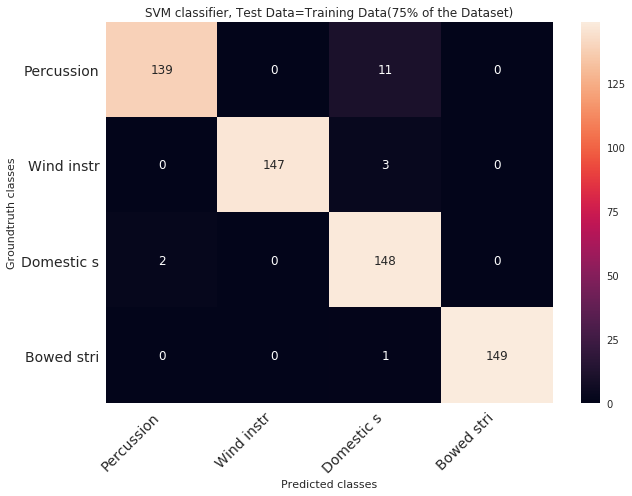

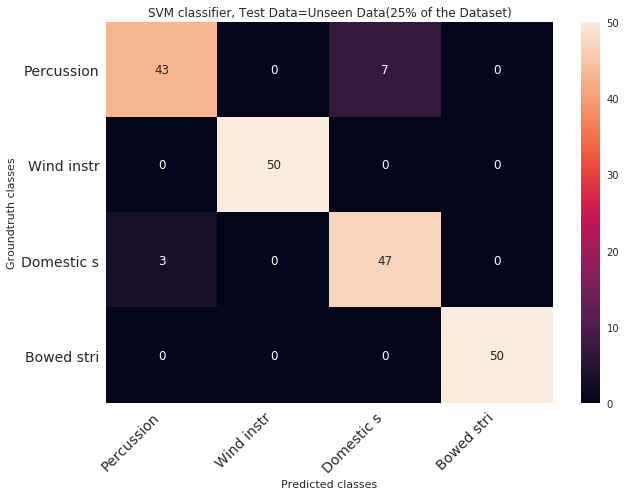

In [112]:
# Expriment using duration

display(HTML('<h2>With Duration as feature</h2>'))

CLASSIFIER_TYPE = 'svm'
PERCENTAGE_OF_TRAINING_DATA = 0.75
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 100
MAX_INPUT_TAGS_FOR_TESTING = 50

def build_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    
    # The newly introduced audio features to the feature set 
    hfc_mean=sound['analysis']['lowlevel']['hfc']['mean']
    average_loudness=sound['analysis']['lowlevel']['average_loudness']
    dissonance_mean=sound['analysis']['lowlevel']['dissonance']['mean']
    pitch_salience=sound['analysis']['lowlevel']['pitch_salience']['mean']    
    spectral_flux=sound['analysis']['lowlevel']['spectral_flux']['mean']
    
    # adding the newly introduced audio features to the tag_features
    tag_features=np.concatenate([[], tag_features, numpy.array([dissonance_mean])])
    tag_features=np.concatenate([[], tag_features, numpy.array([average_loudness])])
    tag_features=np.concatenate([[], tag_features, numpy.array([hfc_mean])])
    tag_features=np.concatenate([[], tag_features, numpy.array([pitch_salience])])
    tag_features=np.concatenate([[], tag_features, numpy.array([spectral_flux])])
    
    tag_features=np.concatenate([[], tag_features])
    return np.concatenate([[], tag_features])

# ------------A code snippet containing a function that can turn off printing to console while iterating long code segments containing function calls which print to console extensively----
import os, sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
# ----------------------------------------------------------------------------------------------------------------------

# CODE TO CLEAN DATASET (remove sounds which do not have analysis information)
avg_accuracy=0
dataset_cleaned = {}
for key, sounds in dataset.items():
    if key not in dataset_cleaned:
        dataset_cleaned[key] = []
    for sound in sounds:
        if sound['analysis'] is not None:
            dataset_cleaned[key].append(sound)

prototype_feature_vector = []
prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset_cleaned, class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)

feature_names = prototype_feature_vector[:]

#Appending the newly introduced audio feature names
feature_names.append('dissonance_mean')
feature_names.append('average_loudness')
feature_names.append('hfc_mean')
feature_names.append('pitch_salience')
feature_names.append('spectral_flux')

classifier = train_classifier(
    training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
    feature_vector_func=build_feature_vector, feature_vector_dimension_labels=feature_names,
)

accuracy=evaluate_classifier(
    testing_set=training_set, classifier=classifier, class_names=class_names, 
    feature_vector_func=build_feature_vector,
    caption='SVM classifier, Test Data=Training Data(75% of the Dataset)')
print("Accuracy for SVM classifier over Test Data=Training Data(75% of the Dataset) : "+str(accuracy*100)+" %")

accuracy=evaluate_classifier(
    testing_set=testing_set, classifier=classifier, class_names=class_names, 
    feature_vector_func=build_feature_vector,
    caption='SVM classifier, Test Data=Unseen Data(25% of the Dataset)')
print("Accuracy for SVM classifier over Test Data=Unseen Data(25% of the Dataset) : "+str(accuracy*100)+" %")
